In [1]:
from fastai.text.all import *
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import polars as pl, evaluate

In [2]:
pl.Config.set_fmt_str_lengths(200);

# Transformers

## Example: positional encoding

$$\textit{PE}_{(pos,2i)} = \sin(pos/10000^{2i/d_{model}})$$

$$\textit{PE}_{(pos,2i+1)} = \cos(pos/10000^{2i/d_{model}})$$

where $pos$ is the position and $i$ is the dimension.

In [3]:
dims = 20
max_len = 100

In [4]:
torch.arange(0., dims, 2.)

tensor([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.])

In [5]:
freq = 1 / (10000 ** (torch.arange(0.0, dims, 2.0)/dims))
freq

tensor([1.0000e+00, 3.9811e-01, 1.5849e-01, 6.3096e-02, 2.5119e-02, 1.0000e-02,
        3.9811e-03, 1.5849e-03, 6.3096e-04, 2.5119e-04])

In [6]:
m = torch.outer(torch.arange(max_len), freq)
m.shape

torch.Size([100, 10])

In [7]:
pos_embs = torch.cat([m.sin(), m.cos()], dim=-1)
pos_embs.shape

torch.Size([100, 20])

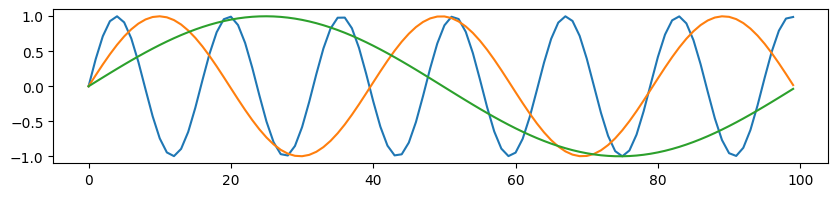

In [8]:
fig,ax = plt.subplots(figsize=(10,2))
# ax.plot(pos_embs[:, 0])
ax.plot(pos_embs[:, 1])
ax.plot(pos_embs[:, 2])
ax.plot(pos_embs[:, 3]);

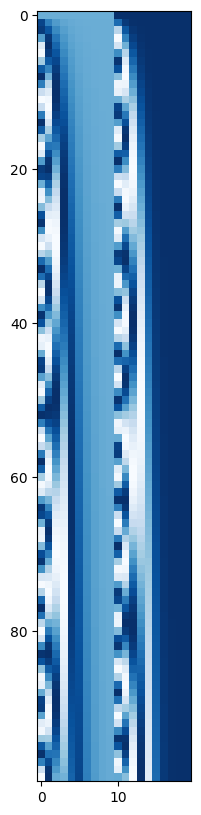

In [9]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(pos_embs, cmap=plt.cm.Blues);

## Data

In [10]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

In [11]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
df = (
    pl.concat([
        pl.scan_csv('emotions-dataset/training.csv').with_columns(is_valid=False),
        pl.scan_csv('emotions-dataset/validation.csv').with_columns(is_valid=True),
    ])
    .with_columns(pl.col.label.replace_strict(labels_dict))
    .collect()
)
print(df.shape)
df.head()

(18000, 3)


text,label,is_valid
str,str,bool
"""i didnt feel humiliated""","""sadness""",false
"""i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake""","""sadness""",false
"""im grabbing a minute to post i feel greedy wrong""","""anger""",false
"""i am ever feeling nostalgic about the fireplace i will know that it is still on the property""","""love""",false
"""i am feeling grouchy""","""anger""",false


In [12]:
ds = Dataset.from_polars(df).rename_columns({'label':'labels'}).class_encode_column('labels')
ds

Stringifying the column:   0%|          | 0/18000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/18000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'labels', 'is_valid'],
    num_rows: 18000
})

In [13]:
model_name = 'answerdotai/ModernBERT-base'

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [15]:
ds[0]

{'text': 'i didnt feel humiliated', 'labels': 4, 'is_valid': False}

In [16]:
tokenizer.tokenize(ds[0]['text'])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhum', 'iliated']

In [17]:
ds_tokenized = ds.map(lambda row: tokenizer(row['text'], truncation=True), batched=True)

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

In [18]:
ds_tokenized

Dataset({
    features: ['text', 'labels', 'is_valid', 'input_ids', 'attention_mask'],
    num_rows: 18000
})

In [19]:
row = ds_tokenized[0]
print(row['text'], '\n----\n', row['input_ids'])

i didnt feel humiliated 
----
 [50281, 74, 42126, 1928, 1547, 31689, 50282]


In [20]:
def get_ds(df):
    return (
        Dataset
        .from_polars(df)
        .rename_columns({'label':'labels'})
        .class_encode_column('labels')
        .map(lambda row: tokenizer(row['text'], max_length=200, truncation=True), batched=True)
    )

In [21]:
ds = DatasetDict({
    'train': df.filter(~pl.col.is_valid).pipe(get_ds),
    'valid': df.filter(pl.col.is_valid).pipe(get_ds),
})
ds

Stringifying the column:   0%|          | 0/16000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/2000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'is_valid', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    valid: Dataset({
        features: ['text', 'labels', 'is_valid', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

## Model

In [22]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels_dict))

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
model

ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      

## Training

In [24]:
bs = 16
epochs = 5
lr = 5e-4

args = TrainingArguments(
    'outputs', learning_rate=lr, bf16=True, eval_strategy='epoch', optim='adamw_torch_fused',
    num_train_epochs=epochs, per_device_train_batch_size=bs, per_device_eval_batch_size=bs,
)

In [25]:
accuracy = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

In [26]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model, args, train_dataset=ds['train'], eval_dataset=ds['valid'], processing_class=tokenizer,
    data_collator=data_collator, compute_metrics=compute_metrics
)

In [27]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.378500,0.262267,0.908500
2,0.197800,0.221132,0.921000
3,0.115300,0.201565,0.927000
4,0.061800,0.259897,0.923000
5,0.023000,0.336632,0.923500


TrainOutput(global_step=5000, training_loss=0.23683227043151855, metrics={'train_runtime': 498.8605, 'train_samples_per_second': 160.365, 'train_steps_per_second': 10.023, 'total_flos': 2501860238582976.0, 'train_loss': 0.23683227043151855, 'epoch': 5.0})

In [28]:
ds['train'].features['labels']._int2str

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [29]:
preds = trainer.predict(ds['valid']).predictions.argmax(1)
preds

array([4, 4, 3, ..., 2, 2, 2], shape=(2000,))

In [30]:
lbls = ds['train'].features['labels']
lbls

ClassLabel(names=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])

In [31]:
results = pl.DataFrame({
    'text': ds['valid']['text'],
    'label': lbls.int2str(ds['valid']['labels']),
    'pred': lbls.int2str(preds)
})
results.head()

text,label,pred
str,str,str
"""im feeling quite sad and sorry for myself but ill snap out of it soon""","""sadness""","""sadness"""
"""i feel like i am still looking at a blank canvas blank pieces of paper""","""sadness""","""sadness"""
"""i feel like a faithful servant""","""love""","""love"""
"""i am just feeling cranky and blue""","""anger""","""anger"""
"""i can have for a treat or if i am feeling festive""","""joy""","""joy"""


In [32]:
(
    results
    .group_by('label')
    .agg(
        pl.len(),
        (pl.col.label==pl.col.pred).mean().alias('accuracy'),
    )
    .sort('label')
)

label,len,accuracy
str,u32,f64
"""anger""",275,0.916364
"""fear""",212,0.872642
"""joy""",704,0.950284
"""love""",178,0.842697
"""sadness""",550,0.961818
"""surprise""",81,0.765432


In [33]:
results.filter(pl.col.label!=pl.col.pred).head()

text,label,pred
str,str,str
"""i don t know if anybody will ever be able to feel how i feel or at least relate when everything is lost you find yourself missing and longing for it them""","""sadness""","""love"""
"""i feel as if i am the beloved preparing herself for the wedding""","""joy""","""love"""
"""i feel like taking a whack at someone s eye and spitting on it a cranky old lady i try to cheer myself up""","""anger""","""sadness"""
"""i cant sleep i switch on music if i need to wake up i switch on music if i feel morose music it is that comes to my rescue whenever i feel ecstatic the tunes are by my side if i want to meet my wild s…","""sadness""","""joy"""
"""i miss our talks our cuddling our kissing and the feelings that you can only share with your beloved""","""love""","""joy"""
